# WeatherPy
----
### Background / Issues
* Goal:  understand how the weather changes as one approaches the equator
* Basic approach:  Use openweathermap API to sample weather in cities using the citipy dataset and examine the effects of latitude
* Issues:  "City weather" is quite different from weather in general.  Cities are on land, tend to be near large bodies of water, and tend not to be at high elevation, in polar regions, on rugged terrain, in deserts, etc.  So, the more specific question that we will answer is "how does the weather in cities change as one approaches the equator?"
* Please see the "README" deisgn doc for more detailed discussion and instructions for use.


### Analysis
* As expected, the weather becomes significantly warmer as one approaches the equator (0 Deg. Latitude). More interestingly, however, is the fact that the southern hemisphere tends to be warmer this time of year than the northern hemisphere. This may be due to the tilt of the earth.
* There is no strong relationship between latitude and cloudiness. However, it is interesting to see that a strong band of cities sits at 0, 80, and 100% cloudiness.
* There is no strong relationship between latitude and wind speed. However, in northern hemispheres there is a flurry of cities with over 20 mph of wind.

---

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [36]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import openweathermapy.core as owm
import time
import urllib
from haversine import haversine
# Import API key
from config import api_key

# Incorporated haversine library to calculate distances
# from haversine import haversine

# Input File (CSV)
input_data_file = 'citipy/worldcities.csv'

# Output File (CSV)
output_data_file = 'output_data/cities.csv'

# Output log File (TXT)
output_log = 'output_data/log.txt'

### Code Parameters 

In [40]:
# Constants
# lat_radius will control the size of the search radius (in distance equal to deg lat, 
# which means 1.0 = 111 km, 2.0 = 222 km, etc.  Smaller = longer time to build city list
# but larger = less perfect sampling of population.  Note that city locations are not
# meaningful at less than 10 km resolution, that is, lat_radius < 0.1.  
lat_radius = 1.0
# To help with server load, the notebook will acquire weather for data_size cities, but
# will do so by running up to max_batches queries of batch_size.  Because not every
# query may be successful, max_batches is recommended to allow data_size with some margin.
# To keep from making unlimited queries, however, the search will end even if data_size records
# are not returned.  
batch_size = 20
data_size = 500
max_batches = 40
# wlr is a 'padded' margin of water to land area on Earth's surface (actually about 3 to 1)
# This parameter can be increased if the notebook warns you it can't find enough cities
wlr = 6        #Use an integer

### Prepare City Data
By importing directly from the csv, we lose the kd-tree structure from citipy, but we gain the ability to
do the appropriate math.

In [41]:
# Read the DataFrame, sort by latitude (then longitude), and use the latitude as the index
city_df = pd.read_csv(input_data_file).sort_values(by=['Latitude','Longitude']).set_index('Latitude', drop=False)
# A latitude-based index will speed up the city search greatly later.
city_df.head()

Country          City   Latitude   Longitude
Latitude                                               
-54.800000      ar       ushuaia -54.800000  -68.300000
-53.150000      cl  punta arenas -53.150000  -70.916667
-51.622613      ar  rio gallegos -51.622613  -69.218127
-46.600000      nz         bluff -46.600000  168.333333
-46.400000      nz  invercargill -46.400000  168.350000

## Generate Cities List

In [42]:
def getcities(batch=batch_size, radius = lat_radius, found = []):
    '''Returns a list of city names with length equal to batch.  In practice, this means transforming
    the latitude distribution by an inverse cosine to give appropriately gerater probability to points
    along the equator and vanishingly small probability of points approaching the poles. Once a point
    is selected, a search for cities using the global city_df is made, and the nearest city having
    a distance less than 'radius' (in latitude degrees, 1 deg = 111.13 km) is selected.'''
# List for holding city names and search count.  For safety, we will terminate at a fixed number of searches.
    cities = []
    searches = 0
    max_searches = wlr * batch  #wlr = approx area ratio of water to land on Earth, with some margin for error
# Loop through until we get the required number of successes
    while len(cities) <  batch and searches <= max_searches:
        city_name = ''
        max_dist = 111.13 * radius  #Converts latitude degrees to km, based on average radius of Earth
        # Choose a random point on Earth's surface
        lat = 180.0 / 3.1416 *  np.arccos(2 * np.random.rand() -1) - 90
        lng = 360.0 * np.random.rand() - 180.0
        # The search is a two-part filter.  The first is a direct filter of any place with the wrong lats 
        # We do not filter on lngs because the modular arithmetic and nonlinearity make it quite complex.  
        search_df = city_df.loc[lat - radius : lat + radius,:]
        # Now we can search through a much smaller list to look for the nearest city
        # Here we use df.iat for fast look-up, with only numbers for indices (city name = 1, lat = 2, lng = 3)
        if not search_df.empty:
            #Many latitudes will have no cities, so these get skipped altogether
            for ix in range(len(search_df)):
                dist = haversine((lat, lng),(search_df.iat[ix,2],search_df.iat[ix,3]))
            # The second part of the search is a simple minimum finder initialized to the maximum permitted value.
                if dist < max_dist and (search_df.iat[ix,1] not in cities) and (search_df.iat[ix,1 not in found):
                    city_name = search_df.iat[ix,1]
                    max_dist = dist
        # Append the nearest city if we found one
        if city_name:
            cities.append(city_name)
        searches += 1
        if searches > max_searches:
            print('Not finding many cities. Please increase the parameters lat_radius and/or wlr.')
    print(f'Batch complete, {len(cities)} found.')
    return cities

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [43]:
# Create settings for API call
settings = {'units':'imperial','appid':api_key}
# Set up objects to hold results and count of attempts and successes
batch_num = 0
citycount = 0
cityfound = []
countryfound = []
tempfound = []
humidfound = []
windfound = []
cloudfound = []
latfound = []
lngfound = []
whenfound = []
# Get the data in batches so as to not overwhelm server ...
with open(output_log,'w') as f:
    while citycount < data_size and batch_num < max_batches:
        # Initialize a batch
        batch_num += 1
        attempt_num = 0
        f.write(f'Beginning data collection batch {batch_num}:\n')
        print(f'Building batch number {batch_num}')
        # Get cities in a batch
        citylist = getcities(batch_size, lat_radius, cityfound)
        while attempt_num < len(citylist):
            # Now attempt to access one city at a time
            city = citylist[attempt_num]
            attempt_num += 1
            # Reset temp holders, using physically meaningless values to indicate missing data
            tmpcity, tmpcountry, tmptemp, tmphumid, tmpwind, tmpclouds, tmplat, tmplng = '','',-99,-99,-99,-99,-99,-199
            # Log request
            print('Requesting weather for ' + city + '...')
            reqtime = datetime.now()
            f.write('Request city: ' + city + ' at ' + reqtime.strftime('%m/%d/%Y, %H:%M:%S') + '\n')
            # Make request from openweathermap
            try:
                weather = owm.get_current(city, **settings)
                # Store results in temporary objects for checking, enforce types for later
                tmpcity = weather['name']
                tmpcountry = weather['sys']['country']
                tmptemp = float(weather['main']['temp'])
                tmphumid = float(weather['main']['humidity'])
                tmpwind = float(weather['wind']['speed'])
                tmpclouds = float(weather['clouds']['all'])
                tmplat = float(weather['coord']['lat'])
                tmplng = float(weather['coord']['lon'])
                # Log data 
                reqtime = datetime.now()
                f.write('Response at ' + reqtime.strftime('%m/%d/%Y, %H:%M:%S') + '\n')
                f.write('City: ' + tmpcity + ' Country: ' + tmpcountry)
                f.write(' Temp: ' + str(tmptemp) + ' Humidity: ' + str(tmphumid))       
                f.write(' Wind: ' + str(tmpwind) + ' Cloud cover: ' + str(tmpclouds))    
                f.write(' Lat: ' + str(tmplat) + ' Lng: ' + str(tmplng) + '\n')
            except urllib.request.HTTPError:
                print('HTTP Error')
                f.write('HTTP Request Failed\n')
            except KeyError:
                print('Weather data not found.')
                f.write('Weather data not found.\n')
            # Only record data if all missing values are filled in with meaningful data (when possible to check)
            if all ((tmpcity != '', tmpcountry !='', tmptemp > -99, tmphumid >=0,\
                        tmpwind >=0, tmpclouds >=0, tmplat >=-90, tmplng >=-180)):
                print('Succes. City: '+ tmpcity + ' found. Raw data in file')
                f.write('Success.  Appending data.\n')
                # In this case, increment success counter and append data to lists
                citycount += 1
                cityfound.append(tmpcity)
                countryfound.append(tmpcountry)
                tempfound.append(tmptemp)
                humidfound.append(tmphumid)
                windfound.append(tmpwind)
                cloudfound.append(tmpclouds)
                latfound.append(tmplat)
                lngfound.append(tmplng)
                whenfound.append(reqtime)
            else: #If not all parameters were successful, note it and move on to next.
                print('There was a problem with this request.  Noted in file')
                f.write('Data does not meet criteria and will not be used.\n')
        if len(cityfound) < data_size:  #Pause requests if we need to get more
            print('Giving the server a break ...')
            time.sleep(3)

Building batch number 1
Batch complete, 20 found.
Requesting weather for tupik...
Succes. City: Tupik found. Raw data in file
Requesting weather for vologda...
Succes. City: Vologda found. Raw data in file
Requesting weather for maumere...
Succes. City: Maumere found. Raw data in file
Requesting weather for kurumkan...
Succes. City: Kurumkan found. Raw data in file
Requesting weather for benghazi...
Succes. City: Benghazi found. Raw data in file
Requesting weather for ust-tsilma...
Succes. City: Ust-Tsilma found. Raw data in file
Requesting weather for sigli...
Succes. City: Sigli found. Raw data in file
Requesting weather for yuancheng...
HTTP Error
There was a problem with this request.  Noted in file
Requesting weather for netrakona...
Succes. City: Netrakona found. Raw data in file
Requesting weather for maniitsoq...
Succes. City: Maniitsoq found. Raw data in file
Requesting weather for umm jarr...
HTTP Error
There was a problem with this request.  Noted in file
Requesting weather 

Succes. City: Laurel found. Raw data in file
Requesting weather for ushibuka...
Succes. City: Ushibuka found. Raw data in file
Requesting weather for port augusta...
Succes. City: Port Augusta found. Raw data in file
Giving the server a break ...
Building batch number 6
Batch complete, 20 found.
Requesting weather for preston...
Succes. City: Preston found. Raw data in file
Requesting weather for tombouctou...
Succes. City: Timbuktu found. Raw data in file
Requesting weather for wadi musa...
Succes. City: Wadi Musa found. Raw data in file
Requesting weather for horsham...
Succes. City: Horsham found. Raw data in file
Requesting weather for nisia floresta...
Succes. City: Nisia Floresta found. Raw data in file
Requesting weather for derzhavinsk...
Succes. City: Derzhavinsk found. Raw data in file
Requesting weather for mweka...
Succes. City: Mweka found. Raw data in file
Requesting weather for yumen...
Succes. City: Yumen found. Raw data in file
Requesting weather for coalinga...
Succes

Succes. City: Northam found. Raw data in file
Requesting weather for marsabit...
Succes. City: Marsabit found. Raw data in file
Requesting weather for tahoua...
Succes. City: Tahoua found. Raw data in file
Requesting weather for vangaindrano...
Succes. City: Vangaindrano found. Raw data in file
Requesting weather for visby...
Succes. City: Visby found. Raw data in file
Requesting weather for assiniboia...
Succes. City: Assiniboia found. Raw data in file
Requesting weather for eirunepe...
Succes. City: Eirunepe found. Raw data in file
Requesting weather for lang son...
Succes. City: Lang Son found. Raw data in file
Requesting weather for sembe...
HTTP Error
There was a problem with this request.  Noted in file
Giving the server a break ...
Building batch number 11
Not finding many cities. Please increase the parameters lat_radius and/or wlr.
Batch complete, 15 found.
Requesting weather for sabathu...
Succes. City: Sabathu found. Raw data in file
Requesting weather for zyryanka...
Succes

Succes. City: Panguna found. Raw data in file
Requesting weather for villazon...
HTTP Error
There was a problem with this request.  Noted in file
Requesting weather for alto baudo...
HTTP Error
There was a problem with this request.  Noted in file
Requesting weather for norrtalje...
Succes. City: Norrtalje found. Raw data in file
Requesting weather for bongandanga...
Succes. City: Bongandanga found. Raw data in file
Requesting weather for falkenberg...
Succes. City: Falkenberg found. Raw data in file
Requesting weather for kutum...
Succes. City: Kutum found. Raw data in file
Requesting weather for grafton...
Succes. City: Grafton found. Raw data in file
Requesting weather for kahului...
Succes. City: Kahului found. Raw data in file
Giving the server a break ...
Building batch number 16
Batch complete, 20 found.
Requesting weather for yenagoa...
Succes. City: Yenagoa found. Raw data in file
Requesting weather for marabba...
Succes. City: Marabba found. Raw data in file
Requesting weathe

Succes. City: Bouca found. Raw data in file
Requesting weather for ponta do sol...
Succes. City: Ponta do Sol found. Raw data in file
Requesting weather for rolim de moura...
HTTP Error
There was a problem with this request.  Noted in file
Requesting weather for wagar...
Succes. City: Wagar found. Raw data in file
Requesting weather for zyryanka...
Succes. City: Zyryanka found. Raw data in file
Requesting weather for miranorte...
HTTP Error
There was a problem with this request.  Noted in file
Requesting weather for garissa...
Succes. City: Garissa found. Raw data in file
Requesting weather for caracuaro...
Succes. City: Caracuaro found. Raw data in file
Requesting weather for polis...
Succes. City: Polis found. Raw data in file
Requesting weather for wajir...
Succes. City: Wajir found. Raw data in file
Requesting weather for ancud...
Succes. City: Ancud found. Raw data in file
Requesting weather for jining...
Succes. City: Jining found. Raw data in file
Requesting weather for hermanus

HTTP Error
There was a problem with this request.  Noted in file
Requesting weather for pathalgaon...
Succes. City: Pathalgaon found. Raw data in file
Requesting weather for sesheke...
Succes. City: Sesheke found. Raw data in file
Giving the server a break ...
Building batch number 25
Not finding many cities. Please increase the parameters lat_radius and/or wlr.
Batch complete, 16 found.
Requesting weather for birao...
Succes. City: Birao found. Raw data in file
Requesting weather for plastun...
Succes. City: Plastun found. Raw data in file
Requesting weather for remanso...
Succes. City: Remanso found. Raw data in file
Requesting weather for umba...
Succes. City: Umba found. Raw data in file
Requesting weather for tansen...
Succes. City: Tansen found. Raw data in file
Requesting weather for los llanos de aridane...
Succes. City: Los Llanos de Aridane found. Raw data in file
Requesting weather for ponazyrevo...
Succes. City: Ponazyrevo found. Raw data in file
Requesting weather for macu

Succes. City: Nadapuram found. Raw data in file
Requesting weather for bury saint edmunds...
HTTP Error
There was a problem with this request.  Noted in file
Requesting weather for miraflores...
Succes. City: Miraflores found. Raw data in file
Giving the server a break ...
Building batch number 30
Not finding many cities. Please increase the parameters lat_radius and/or wlr.
Batch complete, 18 found.
Requesting weather for montrose...
Succes. City: Montrose found. Raw data in file
Requesting weather for ambovombe...
Succes. City: Ambovombe found. Raw data in file
Requesting weather for belokurikha...
Succes. City: Belokurikha found. Raw data in file
Requesting weather for santa maria...
Succes. City: Santa Maria found. Raw data in file
Requesting weather for riyadh...
Succes. City: Riyadh found. Raw data in file
Requesting weather for biak...
Succes. City: Biak found. Raw data in file
Requesting weather for kakamigahara...
Succes. City: Kakamigahara found. Raw data in file
Requesting w

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [44]:
# Generate DataFrame with the results
weather_df = pd.DataFrame({'City':cityfound,'Country':countryfound,'Latitude':latfound,
                          'Longitude':lngfound,'Time':whenfound,'Temperature (deg F)':tempfound,
                          'Humidity (%)':humidfound,'Wind Speed (mph)':windfound,'Cloud Cover (%)':cloudfound})
weather_df.to_csv(output_data_file)
weather_df

City Country  Latitude  Longitude  \
0                   Tupik      RU     54.43     119.94   
1                 Vologda      RU     59.22      39.89   
2                 Maumere      ID     -8.63     122.22   
3                Kurumkan      RU     54.33     110.32   
4                Benghazi      LY     32.12      20.07   
5              Ust-Tsilma      RU     65.44      52.15   
6                   Sigli      ID      5.38      95.96   
7               Netrakona      BD     24.88      90.72   
8               Maniitsoq      GL     65.42     -52.90   
9                    Orda      RU     57.20      56.91   
10               Espinosa      BR    -14.92     -42.81   
11           Baloda Bazar      IN     21.65      82.17   
12                Karachi      PK     24.87      67.03   
13                  Mekhe      SN     15.11     -16.62   
14               Timbuktu      ML     16.77      -3.01   
15            Juxtlahuaca      MX     17.43     -99.15   
16             Rio Grande      BR    -32.03     -52.10   
17                 Kiunga      PG     -6.12     141.30   
18     North Myrtle Beach      US     33.83     -78.68   
19                  Bouca      CF      6.51      18.28   
20                Qandala      SO     11.47      49.87   
21          Santa Barbara      US     34.42    -119.70   
22              Mangaldai      IN     26.43      92.03   
23            Miandrivazo      MG    -19.53      45.46   
24                Melfort      CA     52.87    -104.61   
25                 Palmas      BR    -10.18     -48.33   
26               Balakovo      RU     52.02      47.82   
27                 Atuona      PF     -9.80    -139.03   
28                  Weihe      CN     32.99     105.33   
29                   Adet      ET     11.26      37.49   
..                    ...     ...       ...        ...   
477                Noumea      NC    -22.28     166.46   
478         Pimenta Bueno      BR    -11.68     -61.19   
479                  Goya      AR    -29.14     -59.27   
480             Zavetnoye      RU     47.12      43.89   
481               Husavik      CA     50.56     -96.99   
482               Mabamba      TZ     -3.60      30.50   
483               Mae Sot      MM     16.71      98.57   
484             Pukhrayan      IN     26.23      79.84   
485                 Mongo      CF      4.83      22.92   
486            Thabazimbi      ZA    -24.59      27.41   
487               Erenhot      CN     43.65     111.97   
488             Nadapuram      IN     11.70      75.65   
489            Miraflores      CO      5.20     -73.14   
490              Montrose      AU    -37.81     145.34   
491             Ambovombe      MG    -25.18      46.09   
492           Belokurikha      RU     52.00      84.99   
493           Santa Maria      BR    -29.69     -53.81   
494                Riyadh      SA     24.63      46.72   
495                  Biak      ID     -0.91     122.88   
496          Kakamigahara      JP     35.40     136.85   
497                Ouesso      CG      1.61      16.05   
498                 Bouar      CF      5.94      15.59   
499              Tshikapa      CD     -6.42      20.79   
500  Vershino-Darasunskiy      RU     52.35     115.52   
501                 Zeitz      DE     51.05      12.13   
502             Harnosand      SE     62.63      17.94   
503               Vizinga      RU     61.08      50.08   
504          Fayetteville      US     36.06     -94.16   
505              Barguzin      RU     53.62     109.63   
506                Gaoual      GN     11.75     -13.20   

                          Time  Temperature (deg F)  Humidity (%)  \
0   2019-03-28 22:34:53.005643                23.18          38.0   
1   2019-03-28 22:34:53.282849                29.75          94.0   
2   2019-03-28 22:34:53.670821                82.58         100.0   
3   2019-03-28 22:34:54.075568                21.56          64.0   
4   2019-03-28 22:34:54.646886                58.55         100.0   
5   2019-0

### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

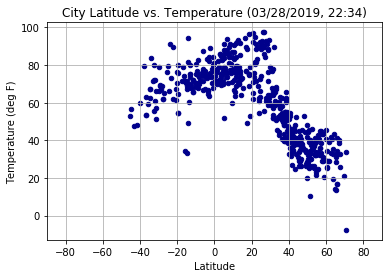

In [45]:
weather_df.plot(kind='scatter',x='Latitude',y='Temperature (deg F)',
                title='City Latitude vs. Temperature (%s)' % weather_df.loc[0,'Time'].strftime('%m/%d/%Y, %H:%M'),
                grid=True,xlim=(-90,90),color='darkblue')
plt.savefig('output_data/lat_v_temp.png')

#### Latitude vs. Humidity Plot

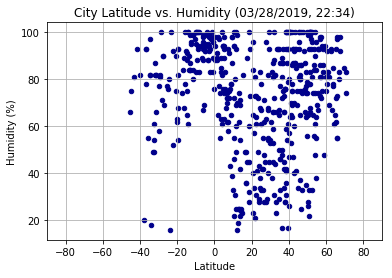

In [46]:
weather_df.plot(kind='scatter',x='Latitude',y='Humidity (%)',
                title='City Latitude vs. Humidity (%s)' % weather_df.loc[0,'Time'].strftime('%m/%d/%Y, %H:%M'),
                grid=True,xlim=(-90,90),color='darkblue')
plt.savefig('output_data/lat_v_humid.png')

#### Latitude vs. Cloudiness Plot

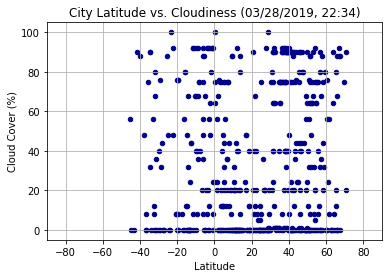

In [47]:
weather_df.plot(kind='scatter',x='Latitude',y='Cloud Cover (%)',
                title='City Latitude vs. Cloudiness (%s)' % weather_df.loc[0,'Time'].strftime('%m/%d/%Y, %H:%M'),
                grid=True,xlim=(-90,90),color='darkblue')
plt.savefig('output_data/lat_v_cloud.png')

#### Latitude vs. Wind Speed Plot

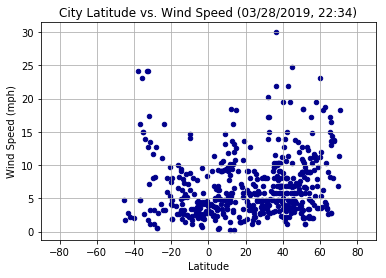

In [48]:
weather_df.plot(kind='scatter',x='Latitude',y='Wind Speed (mph)',
                title='City Latitude vs. Wind Speed (%s)' % weather_df.loc[0,'Time'].strftime('%m/%d/%Y, %H:%M'),
                grid=True,xlim=(-90,90),color='darkblue')
plt.savefig('output_data/lat_v_wind.png')

In [49]:
weather_df['City'].nunique()

490

In [67]:
rs = weather_df.corr(method='spearman')
r_temp = rs.iat[2,0]
r_humid = rs.iat[3,0]
r_wind = rs.iat[4,0]
r_cloud = rs.iat[5,0]
rs

Latitude  Longitude  Temperature (deg F)  Humidity (%)  \
Latitude             1.000000   0.047178            -0.726350     -0.070834   
Longitude            0.047178   1.000000             0.168063     -0.274746   
Temperature (deg F) -0.726350   0.168063             1.000000     -0.150199   
Humidity (%)        -0.070834  -0.274746            -0.150199      1.000000   
Wind Speed (mph)     0.219683   0.011707            -0.105762     -0.161997   
Cloud Cover (%)      0.050952  -0.077121            -0.129454      0.292784   

                     Wind Speed (mph)  Cloud Cover (%)  
Latitude                     0.219683         0.050952  
Longitude                    0.011707        -0.077121  
Temperature (deg F)         -0.105762        -0.129454  
Humidity (%)                -0.161997         0.292784  
Wind Speed (mph)             1.000000         0.088956  
Cloud Cover (%)              0.088956         1.000000

Howell (2013) - Statistical Methods for Psychology (8th ed.). provides an approximate test for significant when using Spearman's correlation coefficients, basically the same formula as for Pearson values, but with the caution that the result is qualitative.  The accepted practice is simply to note borderline cases (here if values are only slightly larger than 2) as being marginal candidates for true statistical significance at 95% confidence.

In [68]:
T_temp = r_temp * 488 ** 0.5 / (1 - r_temp * r_temp) ** 0.5
T_humid = r_humid * 488 ** 0.5 / (1 - r_humid * r_humid) ** 0.5
T_wind = r_wind * 488 ** 0.5 / (1 - r_wind * r_wind) ** 0.5
T_cloud = r_cloud * 488 ** 0.5 / (1 - r_cloud * r_cloud) ** 0.5
if abs(T_temp) > 3:
    print('Correlation between temperature and latitude is likely significant at 95% confidence')
elif abs(T_temp) > 2:
    print('Correlation between temperature and latitude is marginally significant at 95% confidence')
if abs(T_humid) > 3:
    print('Correlation between humidity and latitude is likely significant at 95% confidence')
elif abs(T_humid) > 2:
    print('Correlation between humidity and latitude is marginally significant at 95% confidence')
if abs(T_wind) > 3:
    print('Correlation between wind speed and latitude is likely significant at 95% confidence')
elif abs(T_wind) > 2:
    print('Correlation between wind speed and latitude is marginally significant at 95% confidence')
if abs(T_cloud) > 3:
    print('Correlation between cloud cover and latitude is likely significant at 95% confidence')
elif abs(T_cloud) > 2:
    print('Correlation between cloud cover and latitude is marginally significant at 95% confidence')

Correlation between temperature and latitude is likely significant at 95% confidence
Correlation between wind speed and latitude is likely significant at 95% confidence


In [64]:
r_cloud

-0.07712080476482112